In [0]:
!pip install bert-for-tf2
!pip install sentencepiece

### IMPORT

In [0]:
import pandas as pd
import numpy as np
try:
  %tensorflow_version 2.x
except:
  pass
import tensorflow as tf
from google.colab import drive
import tensorflow_hub as hub
import re
from tensorflow.keras import layers
import bert
import random
import math
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model
import pickle
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords
from livelossplot.tf_keras import PlotLossesCallback

In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
X,y =pickle.load(open('/content/drive/My Drive/NewsClassifier/final_dataset','rb'))

#### USING BERT TOKENIZER

In [0]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [0]:
tag2idx ={}
c=0
for tag in set(y):
    tag2idx[tag] = c
    c+=1
idx2tag = { v:k for k,v in tag2idx.items()}

In [0]:
 data_X = [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence)) for sentence in X]
 data_y = [tag2idx[tag] for tag in y]

### SPLITTING OF SKEWED DATA

In [28]:
skf = StratifiedShuffleSplit(n_splits=2,test_size=0.2)
skf.get_n_splits(data_X,data_y )

2

In [0]:
X_array = np.array(data_X)
y_array = np.array(data_y)

In [30]:
for train_index,test_index in skf.split(data_X,data_y):   ## Splitting into train and test_set
  print("TRAIN:", train_index, "TEST:", test_index)
  #print(len(train_index))
  X_train,X_test = X_array[train_index], X_array[test_index]
  y_train,y_test = y_array[train_index], y_array[test_index]


TRAIN: [ 13432  60915 148099 ...  63226 149323  87976] TEST: [132143  87404  16981 ...  50646 187927 130061]
TRAIN: [ 67377 157799   4638 ... 125648  69566  89736] TEST: [111831  84321   5431 ...  30866 134261 155954]


###### PADDING the entire data and truncating to length 20

In [0]:
X_train =tf.keras.preprocessing.sequence.pad_sequences(
    X_train, maxlen=20, dtype='int32', padding='pre', truncating='pre',
    value=0.0
)
X_test =tf.keras.preprocessing.sequence.pad_sequences(
    X_test, maxlen=20, dtype='int32', padding='pre', truncating='pre',
    value=0.0
)

In [32]:
print(X_train.shape)
print(X_test.shape)

(151661, 20)
(37916, 20)


In [33]:
from sklearn.model_selection import train_test_split  ### Splitting into test and cross_validation set
X_val, X_test, y_val, y_test = train_test_split(
     X_test, y_test, test_size=0.5, random_state=42)
print(X_val.shape)
print(X_test.shape)

(18958, 20)
(18958, 20)


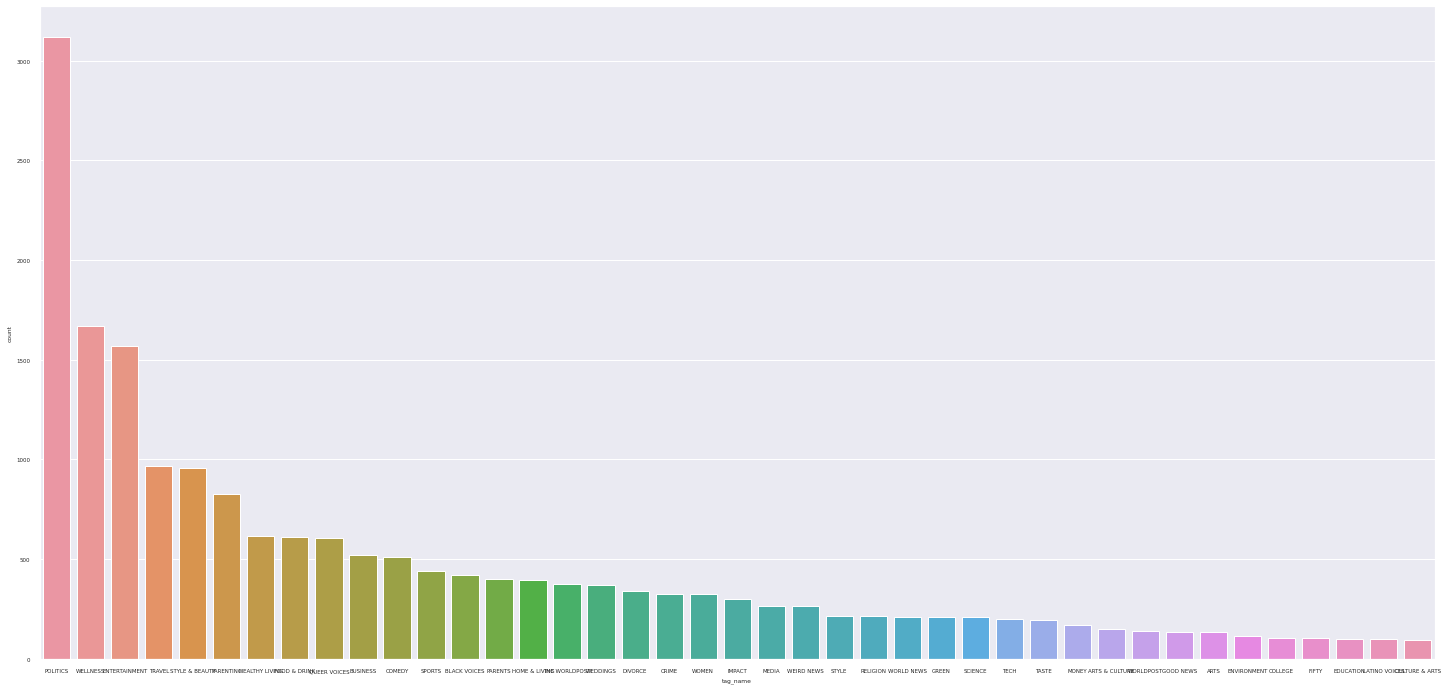

In [34]:
df = pd.DataFrame(y_test,columns=['targets'])             
index = pd.DataFrame(df.targets.value_counts().index)
counts = pd.DataFrame(df.targets.value_counts().values)
concat_df = pd.concat([index,counts],axis=1)
concat_df.columns =['tag','count']
# concat_df.head(2)
labels = [idx2tag[idx] for idx in index]
def get_names(x):
  return idx2tag[x]
concat_df['tag_name'] = concat_df.tag.apply(get_names)
plt.figure(figsize=(25,12))
sns.set(font_scale=0.5)
sns.barplot(x="tag_name",y="count",data=concat_df)       ### Distribution of classes in Training set

### DATASET CREATION

In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset_train = tf.data.Dataset.from_tensor_slices((X_train,y_train))
dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_train = dataset_train.prefetch(tf.data.experimental.AUTOTUNE)

In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset_val = tf.data.Dataset.from_tensor_slices((X_val,y_val))
dataset_val = dataset_val.cache()
dataset_val = dataset_val.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = dataset_val.prefetch(tf.data.experimental.AUTOTUNE)

In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset_test = tf.data.Dataset.from_tensor_slices((X_test,y_test))
dataset_test = dataset_test.cache()
dataset_test = dataset_test.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_test = dataset_test.prefetch(tf.data.experimental.AUTOTUNE)

### MODEL 

In [0]:
tf.compat.v1.reset_default_graph()

In [0]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [0]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 100
CNN_FILTERS = 100
DNN_UNITS = 128
OUTPUT_CLASSES = len(set(y))

DROPOUT_RATE = 0.6

NB_EPOCHS = 20

In [0]:
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [0]:
if OUTPUT_CLASSES == 2:
    text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
else:
    text_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])

#### Checkpoints

In [0]:
checkpoint_directory = "/content/drive/My Drive/NewsClassifier/CNN/New_checks/"
checkpoint = tf.train.Checkpoint(model=text_model) 
manager = tf.train.CheckpointManager(checkpoint,checkpoint_directory,max_to_keep=1)
# if manager.latest_checkpoint:
#   checkpoint.restore(manager.latest_checkpoint) #Restores this Checkpoint and any objects it depends on.
#   print("Latest Checkpoint restored!! ") 

In [0]:
checkpoint_path = "/content/drive/My Drive/NewsClassifier/CNN/Checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
chkpt = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', min_delta=0, patience=3, verbose=1, mode='max',
    baseline=None, restore_best_weights=False
)

callbacks =[chkpt, early_stopping]

### Train

In [161]:
r =text_model.fit(dataset_train,
               epochs=NB_EPOCHS,
               callbacks=callbacks,
               validation_data=dataset_val)
manager.save()

Epoch 1/20
2370/2370 [==============================] - ETA: 0s - loss: 1.9697 - sparse_categorical_accuracy: 0.5007
Epoch 00001: val_loss improved from inf to 1.30727, saving model to /content/drive/My Drive/NewsClassifier/CNN/Checkpoints/cp-0001.ckpt
2370/2370 [==============================] - 73s 31ms/step - loss: 1.9697 - sparse_categorical_accuracy: 0.5007 - val_loss: 1.3073 - val_sparse_categorical_accuracy: 0.6549
Epoch 2/20
2370/2370 [==============================] - ETA: 0s - loss: 1.2898 - sparse_categorical_accuracy: 0.6590
Epoch 00002: val_loss improved from 1.30727 to 1.15143, saving model to /content/drive/My Drive/NewsClassifier/CNN/Checkpoints/cp-0002.ckpt
2370/2370 [==============================] - 73s 31ms/step - loss: 1.2898 - sparse_categorical_accuracy: 0.6590 - val_loss: 1.1514 - val_sparse_categorical_accuracy: 0.6936
Epoch 3/20
2369/2370 [============================>.] - ETA: 0s - loss: 1.0443 - sparse_categorical_accuracy: 0.7131
Epoch 00003: val_loss did n

'/content/drive/My Drive/NewsClassifier/CNN/New_checks/ckpt-1'

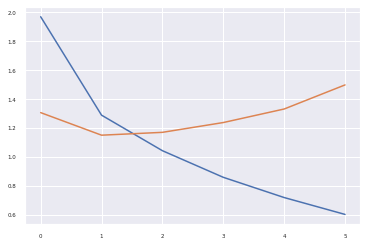

In [162]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])

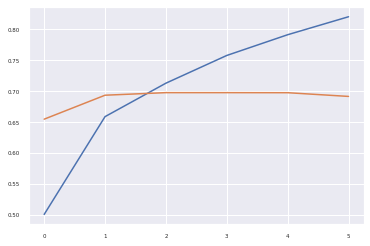

In [163]:
plt.plot(r.history['sparse_categorical_accuracy'])
plt.plot(r.history['val_sparse_categorical_accuracy'])

In [164]:
results = text_model.evaluate(dataset_test)
print(results)

297/297 [==============================] - 1s 3ms/step - loss: 1.5134 - sparse_categorical_accuracy: 0.6925
[1.5134437084197998, 0.6925308704376221]
